# 3. Streaming application using Spark Structured Streaming (60%)
In this task, we will implement Spark Structured Streaming to consume the data from task
1 and perform streaming classification.


Important:

- You may use Spark Structured Streaming together with Spark SQL and ML.
- You are also provided with a set of pre-trained pipeline models to classify the binary classification flight-delays (to be provided soon).


Write a python program that achieves the following requirements. Save the file as
Assignment-2B-Task3_streaming_application.ipynb.


### Import libraries

In [48]:
import os

os.environ[
    "PYSPARK_SUBMIT_ARGS"
] = "--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell"

from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import explode
from pyspark.sql.types import *
from pyspark.ml import PipelineModel
from pyspark.sql.functions import split, udf
from pyspark.sql import functions as F
from time import sleep
import datetime as dt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

### 3.1. SparkSession is created using a SparkConf object, which would use two local cores with a proper application name, and use UTC as the timezone.

In [49]:
# Assign two cores
cores = "local[2]"
# Set app name
appname = "Assignment_2B_Spark_Streaming"
# Set time zone
zone = "UTC"

# Create Spark configuration
spark_conf = (
    SparkConf()
    .setMaster(cores)
    .setAppName(appname)
    .set("spark.sql.session.timeZone", zone)
)

In [50]:
# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

### 3.2 From the Kafka producers in Task 1, ingest the streaming data into Spark Streaming.


In [51]:
topic_name = "flightTopic"

In [52]:
flight = (
    spark.readStream.format("kafka")
    .option("kafka.bootstrap.servers", "127.0.0.1:9092")
    .option("subscribe", topic_name)
    .load()
)

### 3.3. Then the streaming data format should be transformed into the proper formats following the file schema in the metadata.


In [53]:
# Fetch the batch message value
flight = flight.selectExpr("CAST(value AS STRING)")

In [54]:
# define the schema for Flight data
# using only the features used in the model
schema_flight = ArrayType(
    StructType(
        [
            StructField("ts", TimestampType(), True),
            StructField("MONTH", IntegerType(), True),
            StructField("DAY", IntegerType(), True),
            StructField("DAY_OF_WEEK", IntegerType(), True),
            StructField("AIRLINE", StringType(), True),
            StructField("SCHEDULED_DEPARTURE", IntegerType(), True),
            StructField("DEPARTURE_DELAY", FloatType(), True),
            StructField("TAXI_OUT", FloatType(), True),
            StructField("SCHEDULED_TIME", FloatType(), True),
            StructField("ELAPSED_TIME", FloatType(), True),
            StructField("AIR_TIME", FloatType(), True),
            StructField("DISTANCE", IntegerType(), True),
            StructField("TAXI_IN", FloatType(), True),
            StructField("SCHEDULED_ARRIVAL", IntegerType(), True),
            StructField("ARRIVAL_DELAY", FloatType(), True),
        ]
    )
)

In [55]:
# Convert the Json format to matching schema
flight = flight.select(
    F.from_json(F.col("value").cast("string"), schema_flight).alias("Parsed")
)
# Explode the data to extract data from the dictionary
flight = flight.select(F.explode(F.col("Parsed")).alias("Parsed"))

In [56]:
# Format the schema
flight_formatted = flight.select(
    F.col("Parsed.ts").alias("ts"),
    F.col("Parsed.MONTH").alias("MONTH"),
    F.col("Parsed.DAY").alias("DAY"),
    F.col("Parsed.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
    F.col("Parsed.AIRLINE").alias("AIRLINE"),
    F.col("Parsed.SCHEDULED_DEPARTURE").alias("SCHEDULED_DEPARTURE"),
    F.col("Parsed.DEPARTURE_DELAY").alias("DEPARTURE_DELAY"),
    F.col("Parsed.TAXI_OUT").alias("TAXI_OUT"),
    F.col("Parsed.SCHEDULED_TIME").alias("SCHEDULED_TIME"),
    F.col("Parsed.ELAPSED_TIME").alias("ELAPSED_TIME"),
    F.col("Parsed.AIR_TIME").alias("AIR_TIME"),
    F.col("Parsed.DISTANCE").alias("DISTANCE"),
    F.col("Parsed.TAXI_IN").alias("TAXI_IN"),
    F.col("Parsed.SCHEDULED_ARRIVAL").alias("SCHEDULED_ARRIVAL"),
    F.col("Parsed.ARRIVAL_DELAY").alias("ARRIVAL_DELAY"),
)

In [57]:
# Create binaryArrival delay and departure delay
flight_formatted = flight_formatted.withColumn(
    "binaryDeptDelay", F.when(flight_formatted.DEPARTURE_DELAY < 0, 0).otherwise(1)
)
flight_formatted = flight_formatted.withColumn(
    "binaryArrDelay", F.when(flight_formatted.ARRIVAL_DELAY < 0, 0).otherwise(1)
)

In [58]:
# Create DEPT_TIME_FLAG for pipeline
flight_formatted = flight_formatted.withColumn(
    "DEPT_TIME_FLAG",
    F.when(flight_formatted.SCHEDULED_DEPARTURE < 500, "midnight")
    .when(
        (
            (flight_formatted.SCHEDULED_DEPARTURE >= 500)
            & (flight_formatted.SCHEDULED_DEPARTURE <= 1100)
        ),
        " Morning",
    )
    .when(
        (
            (flight_formatted.SCHEDULED_DEPARTURE >= 1100)
            & (flight_formatted.SCHEDULED_DEPARTURE <= 1600)
        ),
        " Afternoon",
    )
    .when(
        (
            (flight_formatted.SCHEDULED_DEPARTURE >= 1600)
            & (flight_formatted.SCHEDULED_DEPARTURE <= 2000)
        ),
        " Evening",
    )
    .otherwise("Night"),
)

### 3.4 Persist the transformed streaming data in parquet format for flight data. Flight data should be stored in “flight.parquet” in the same folder of your notebook.


In [59]:
# Store the data in parquet form
flight_parquet = (
    flight_formatted.writeStream.format("parquet")
    .outputMode("append")
    .option("path", "flight.parquet")
    .option("checkpointLocation", "flight.parquet/checkpoint")
    .start()
)

### 3.5 Load the machine learning models given, and use the models to classify whether each flight records are delayed. This is based on the assumption that the data has been labelled.

Using the model provided by Choiru as part of the ED forum is used in this section.
Here will mainly use only the Arrival delay model to create the graphs as this was accepted by Choiru.

In [60]:
persistedModelArrDT = PipelineModel.load("Model/Arr")
persistedModelDeptDT = PipelineModel.load("Model/Dept")

In [61]:
# Transform to get the predictions
flight_predictions_Arr = persistedModelArrDT.transform(flight_formatted)
flight_predictions_Dept = persistedModelDeptDT.transform(flight_formatted)

### 3.6. Using the classification results, monitor the data following the requirements below. For each key in keyFlight = ‘1’, keyFlight = ‘2’, and keyFlight = ‘3’, keep track of the accumulated accuracy for every timestamp in the 2-min window for a total of 6 minutes.


In [62]:
# Set window of 2 minutes to gather all the data.
# perform groupby to calculate the sum of total records for each day of week.
flight_windowed = (
    flight_predictions_Arr.filter(
        "DAY_OF_WEEK = 1 OR DAY_OF_WEEK = 2 OR DAY_OF_WEEK =3"
    )
    .groupby(
        F.window(F.col("ts"), "2 minutes").alias("time_window"),
        "DAY_OF_WEEK",
        "binaryArrDelay",
    )
    .agg(F.count("DAY_OF_WEEK").alias("counts"))
    .select("time_window", "DAY_OF_WEEK", "counts", "binaryArrDelay")
)

In [63]:
# Query the data based on 2 minute window.
flight_query = (
    flight_windowed.writeStream.outputMode("complete")
    .format("memory")
    .queryName("flightq")
    .trigger(processingTime="60 seconds")
    .start()
)

In [64]:
# Function to intialize the plot
def initialise_plot():
    try:
        width = 12
        height = 9
        # create a feature
        fig = plt.figure(figsize=(width, height))
        # include the subplots canvas.
        fig.subplots_adjust(hspace=0.6)
        # define the subplots subplots
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        # Set x and y label with title for both axis
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Count")
        ax1.title.set_text("Timeline vs Count of DAY_OF_WEEK records ")
        ax2.set_xlabel("Time")
        ax2.set_ylabel("Accuracy")
        ax2.title.set_text("Count vs Classification Accuracy of DAY_OF_WEEK")
        # Figure title
        fig.suptitle("Stream data visualization")
        # Show the figure
        fig.show()
        fig.canvas.draw()
        return fig, ax1, ax2
    except Exception as ex:
        print(str(ex))

In [65]:
# Preprocess the dataframe and obtain timestamp in hour,minute and seconds
def processData(item, label):
    pdata = item.pivot_table(
        values=label,
        index=item["time_window"].apply(
            lambda x: x[0].strftime("%H:%M:%S") + "-" + x[1].strftime("%H:%M:%S")
        ),
        columns="DAY_OF_WEEK",
    )
    pdata = pdata.reset_index()
    pdata.columns = ["time_window", "1", "2", "3"]

    return pdata

In [66]:
# function to plot the graph
def plottingFun(plot_data, fig, ax):
    # define the x and y coordinates for the plot
    x = plot_data["time_window"].tolist()
    y1 = plot_data["1"].tolist()
    y2 = plot_data["2"].tolist()
    y3 = plot_data["3"].tolist()
    # plot the line graph for each day of week
    ax.plot(x, y1, label="DOW=1")
    ax.plot(x, y2, label="DOW=2")
    ax.plot(x, y3, label="DOW=3")
    ax.legend(loc="lower right")
    fig.canvas.draw()
    return

<IPython.core.display.Javascript object>


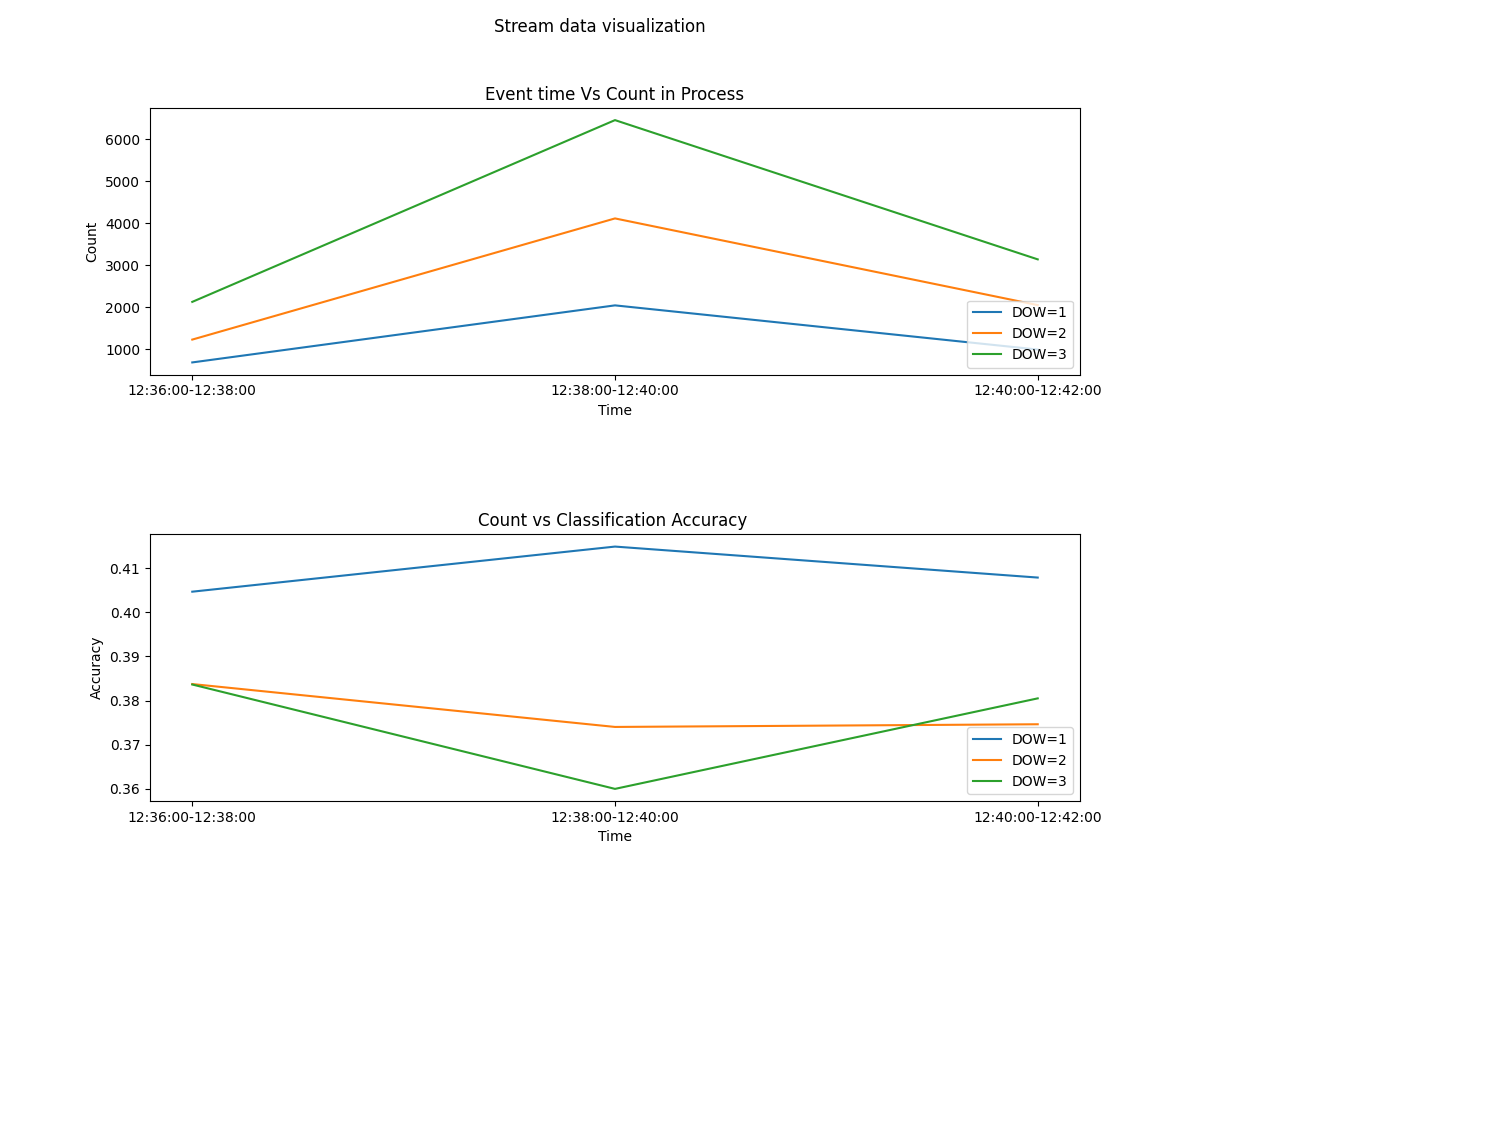

KeyboardInterrupt: 

In [67]:
fig, ax1, ax2 = initialise_plot()
while not False:
    try:
        # Convert the Query data to pandas for plotting
        flight_df_TT = spark.sql(
            "select time_window,DAY_OF_WEEK,binaryArrDelay,counts AS DOW_Count from flightq order by time_window, DAY_OF_WEEK"
        ).toPandas()
        
        # Calculate the Total flights for each day of week
        flight_df_TC = (
            flight_df_TT.groupby(["time_window", "DAY_OF_WEEK"]).sum().reset_index()
        )
        
        # Filter True postives to calculate Accuracy
        flight_df_TT = (
            flight_df_TT[flight_df_TT["binaryArrDelay"] == 1]
            .reset_index()
            .drop("index", axis=1)
        )
        # Join total count and individual day of week counts to calculate accuracy
        flight_df_join = flight_df_TC.join(flight_df_TT, rsuffix="_r")
        
        # Calculate Mean Accumulated Accuracy for each Day of week
        flight_df_join["accumMeanAccuracy"] = (
            flight_df_join.DOW_Count_r / flight_df_join.DOW_Count
        )
        # Drop Na values in DAY of Week columns 
        flight_df_join.dropna(inplace=True)
        
        # Obtain the dataframe for plotting.
        flight_df_join = flight_df_join.loc[
            :, ["time_window", "DAY_OF_WEEK", "DOW_Count", "accumMeanAccuracy"]
        ]

        # print the graph
        ax1.clear()
        ax2.clear()

        # Set x and y label with title for both axis
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Count")
        ax1.title.set_text("Event time Vs Count in Process")
        ax2.set_xlabel("Time")
        ax2.set_ylabel("Accuracy")
        ax2.title.set_text("Count vs Classification Accuracy ")
        # Add figure title
        fig.suptitle("Stream data visualization")

        # pivot table to plot
        figure1 = processData(flight_df_join, "DOW_Count")
        figure2 = processData(flight_df_join, "accumMeanAccuracy")

        # plot the data
        plottingFun(figure1, fig, ax1)
        plottingFun(figure2, fig, ax2)
        
        # delay by 60 seconds to avoid repeated entries
        sleep(60)
    except Exception as ex:
        continue

In [68]:
# stop all services.
flight_query.stop()
flight_parquet.stop()
sc.stop()